In [1]:
import random
import time
from collections import defaultdict
import matplotlib.pyplot as plt


In [2]:
class Section:
    def __init__(self, id, name, grade_level):
        self.id = id
        self.name = name
        self.grade_level = grade_level

class Subject:
    def __init__(self, id, name):
        self.id = id
        self.name = name

class Teacher:
    def __init__(self, id, name, subject_id):
        self.id = id
        self.name = name
        self.subject_id = subject_id

class Schedule:
    def __init__(self, day, time_slot, teacher_id, section_id, subject_id):
        self.day = day
        self.time_slot = time_slot
        self.teacher_id = teacher_id
        self.section_id = section_id
        self.subject_id = subject_id


In [3]:
class MockSession:
    def __init__(self, sections, subjects, teachers):
        self._sections = sections
        self._subjects = subjects
        self._teachers = teachers
        self._schedules = []

    def query(self, model):
        if model == Section:
            return self._sections
        elif model == Subject:
            return self._subjects
        elif model == Teacher:
            return self._teachers
        elif model == Schedule:
            return self._schedules

    def add(self, schedule):
        self._schedules.append(schedule)

    def commit(self):
        pass  # no-op for mock


In [4]:
sections = [Section(1, "Section A", "Grade 7"), Section(2, "Section B", "Grade 8")]
subjects = [Subject(1, "Math"), Subject(2, "Science"), Subject(3, "English")]
teachers = [Teacher(1, "Mr. Smith", 1), Teacher(2, "Ms. Johnson", 2), Teacher(3, "Mr. Lee", 3)]

session = MockSession(sections, subjects, teachers)


In [5]:
class SimpleGeneticScheduler:
    def __init__(self, session, Section, Subject, Teacher, Schedule):
        self.session = session
        self.Section = Section
        self.Subject = Subject
        self.Teacher = Teacher
        self.Schedule = Schedule
        
        self.POPULATION_SIZE = 20
        self.GENERATIONS = 30
        self.MUTATION_RATE = 0.2
        self.CROSSOVER_RATE = 0.7
        
        self.teachers = session.query(Teacher)
        self.sections = session.query(Section)
        self.subjects = session.query(Subject)
        
        self.time_slots = ["7:30-8:30", "8:30-9:30", "9:30-10:30", "10:30-11:30", 
                           "1:00-2:00", "2:00-3:00", "3:00-4:00"]
        self.days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
        
        self.teacher_subjects = self._map_teacher_subjects()
        self.metrics_over_time = []

    def _map_teacher_subjects(self):
        mapping = defaultdict(list)
        for teacher in self.teachers:
            mapping[teacher.id].append(teacher.subject_id)
        return mapping

    def _section_needs_subject(self, section, subject):
        return True

    def _create_individual(self):
        individual = []
        for section in self.sections:
            for subject in self.subjects:
                if not self._section_needs_subject(section, subject):
                    continue
                suitable_teachers = [t.id for t in self.teachers if subject.id in self.teacher_subjects[t.id]]
                if not suitable_teachers:
                    suitable_teachers = [t.id for t in self.teachers]
                gene = {
                    "day": random.choice(self.days),
                    "time_slot": random.choice(self.time_slots),
                    "teacher_id": random.choice(suitable_teachers),
                    "section_id": section.id,
                    "subject_id": subject.id
                }
                individual.append(gene)
        return individual

    def _calculate_fitness(self, individual):
        teacher_slots = defaultdict(int)
        section_slots = defaultdict(int)
        suitability = 0

        for gene in individual:
            teacher_key = (gene['teacher_id'], gene['day'], gene['time_slot'])
            section_key = (gene['section_id'], gene['day'], gene['time_slot'])
            teacher_slots[teacher_key] += 1
            section_slots[section_key] += 1
            if gene['subject_id'] in self.teacher_subjects[gene['teacher_id']]:
                suitability += 1

        teacher_conflicts = sum(count - 1 for count in teacher_slots.values() if count > 1)
        section_conflicts = sum(count - 1 for count in section_slots.values() if count > 1)
        fitness = 1000 - (15 * teacher_conflicts + 15 * section_conflicts - 2 * suitability)
        fitness = max(1, fitness)

        metrics = {
            "fitness_score": fitness,
            "teacher_conflicts": teacher_conflicts,
            "section_conflicts": section_conflicts,
            "teacher_subject_suitability": suitability
        }
        return fitness, metrics

    def _roulette_selection(self, population, fitnesses):
        total_fitness = sum(fitnesses)
        if total_fitness == 0:
            return random.sample(population, len(population))
        selected = []
        for _ in range(len(population)):
            pick = random.uniform(0, total_fitness)
            current = 0
            for i, fitness in enumerate(fitnesses):
                current += fitness
                if current >= pick:
                    selected.append(population[i])
                    break
        return selected

    def _crossover(self, p1, p2):
        if random.random() > self.CROSSOVER_RATE:
            return p1[:], p2[:]
        point = random.randint(1, len(p1) - 1)
        return p1[:point] + p2[point:], p2[:point] + p1[point:]

    def _mutation(self, individual):
        for gene in individual:
            if random.random() < self.MUTATION_RATE:
                choice = random.choice(['day', 'time_slot', 'teacher_id'])
                if choice == 'day':
                    gene['day'] = random.choice(self.days)
                elif choice == 'time_slot':
                    gene['time_slot'] = random.choice(self.time_slots)
                elif choice == 'teacher_id':
                    subject_id = gene['subject_id']
                    suitable_teachers = [t.id for t in self.teachers if subject_id in self.teacher_subjects[t.id]]
                    gene['teacher_id'] = random.choice(suitable_teachers) if suitable_teachers else gene['teacher_id']
        return individual

    def run_algorithm(self):
        population = [self._create_individual() for _ in range(self.POPULATION_SIZE)]
        fitnesses = [self._calculate_fitness(ind)[0] for ind in population]
        best_fitness = max(fitnesses)
        best_individual = population[fitnesses.index(best_fitness)]

        for gen in range(self.GENERATIONS):
            selected = self._roulette_selection(population, fitnesses)
            new_pop = []
            for i in range(0, len(selected), 2):
                if i+1 < len(selected):
                    c1, c2 = self._crossover(selected[i], selected[i+1])
                    new_pop.append(self._mutation(c1))
                    new_pop.append(self._mutation(c2))
                else:
                    new_pop.append(self._mutation(selected[i]))

            new_pop = new_pop[:self.POPULATION_SIZE]
            fitnesses = [self._calculate_fitness(ind)[0] for ind in new_pop]
            current_best = max(fitnesses)
            best_in_gen = new_pop[fitnesses.index(current_best)]
            if current_best > best_fitness:
                best_fitness = current_best
                best_individual = best_in_gen
            gen_metrics = self._calculate_fitness(best_in_gen)[1]
            gen_metrics["generation"] = gen
            self.metrics_over_time.append(gen_metrics)
            population


In [6]:
scheduler = SimpleGeneticScheduler(session, Section, Subject, Teacher, Schedule)
best_schedule = scheduler.run_algorithm()


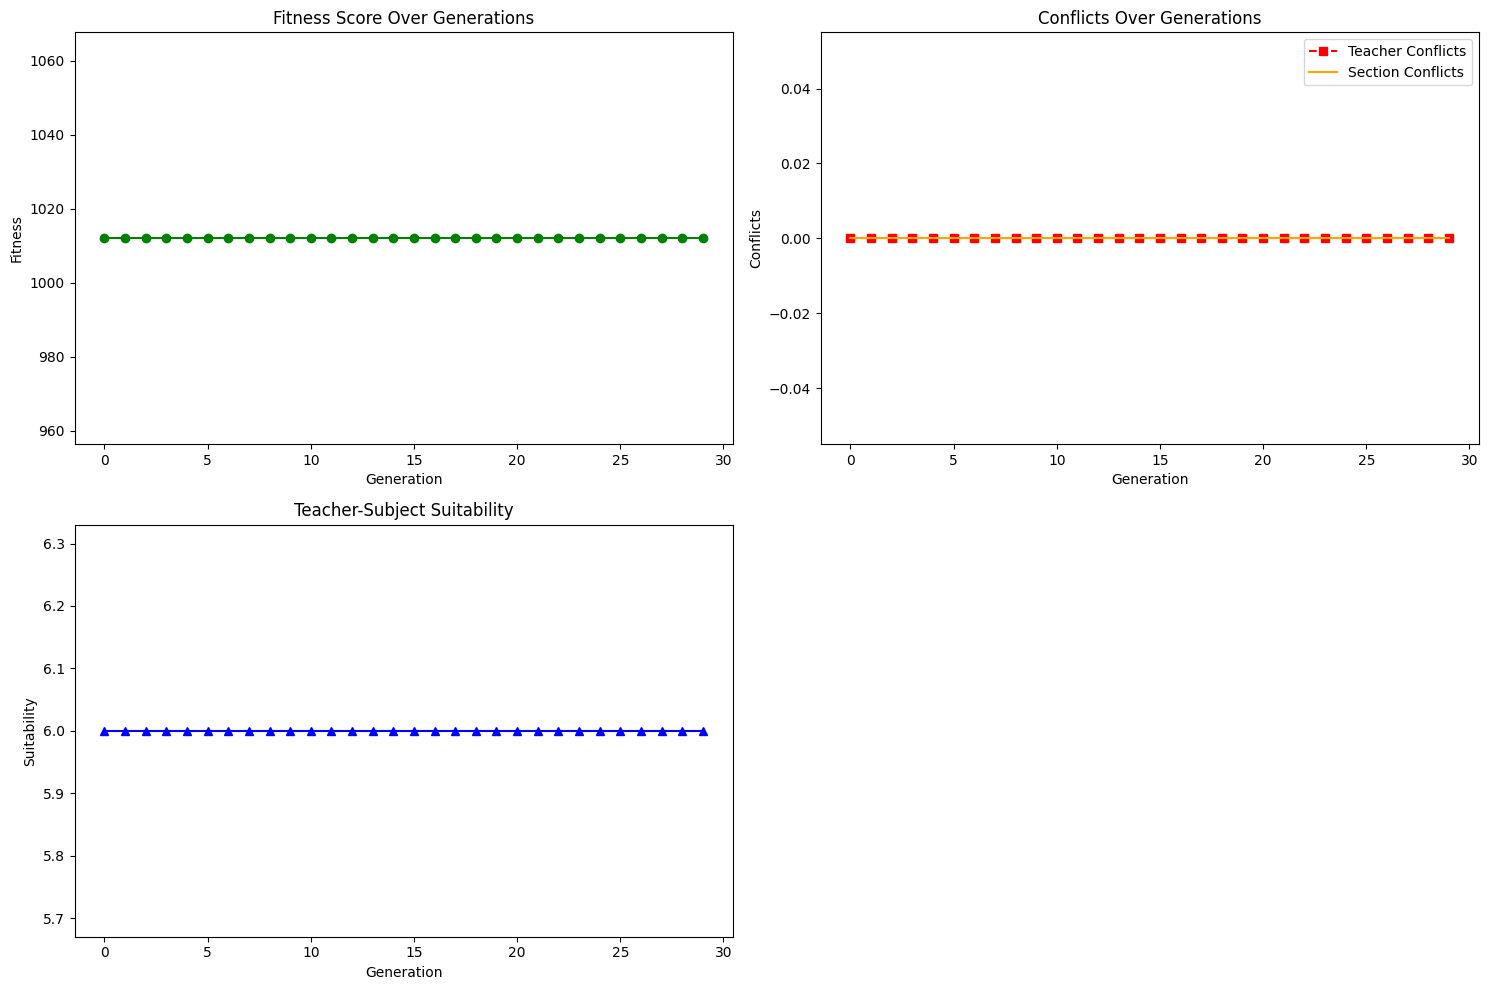

In [7]:
generations = [m['generation'] for m in scheduler.metrics_over_time]
fitness = [m['fitness_score'] for m in scheduler.metrics_over_time]
t_conflicts = [m['teacher_conflicts'] for m in scheduler.metrics_over_time]
s_conflicts = [m['section_conflicts'] for m in scheduler.metrics_over_time]
suitability = [m['teacher_subject_suitability'] for m in scheduler.metrics_over_time]

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(generations, fitness, 'g-o')
plt.title("Fitness Score Over Generations")
plt.xlabel("Generation")
plt.ylabel("Fitness")

plt.subplot(2, 2, 2)
plt.plot(generations, t_conflicts, 'r--s', label="Teacher Conflicts")
plt.plot(generations, s_conflicts, 'orange', label="Section Conflicts")
plt.title("Conflicts Over Generations")
plt.xlabel("Generation")
plt.ylabel("Conflicts")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(generations, suitability, 'b-^')
plt.title("Teacher-Subject Suitability")
plt.xlabel("Generation")
plt.ylabel("Suitability")

plt.tight_layout()
plt.show()
